# <center>Neural Network model without using keras</center>

In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)
x_train = x_train.reshape(x_train.shape[0], 784) / 255
x_test = x_test.reshape(x_test.shape[0], 784) / 255

In [7]:
class NormalLayer(tf.Module):
    
    def __init__(self, input_size, output_size, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.output_size = output_size
        
        self.w = tf.Variable(tf.random.normal([input_size, output_size]) * tf.sqrt(2 / (input_size + output_size)), name='w')
        self.b = tf.Variable(0.0, name='b')
        
    def __call__(self, X):
        """ 
        ReLu activation function
        """
        return tf.maximum(0.0, X @ self.w + self.b)

In [8]:
class FinalLayer(tf.Module):
    
    def __init__(self, input_size, output_size, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.output_size = output_size
        
        self.w = tf.Variable(tf.random.normal([input_size, output_size]) * tf.sqrt(2 / (input_size + output_size)), name='w')
        self.b = tf.Variable(0.0, name='b')
        
    def __call__(self, X):  
        return tf.nn.softmax(X @ self.w + self.b)

In [38]:
class NNModel(tf.Module):
    
    def __init__(self, layers, **kwargs):
        super().__init__(**kwargs)
    
        self.layers = layers
        self.training_loss= []
        self.testing_loss = []
        
    def train(self, X_tr, y_tr, X_ts, y_ts, learning_rate, epoch):
        
        for i in range(epoch):
            
            with tf.GradientTape(persistent=True) as t:
                current_loss = self.loss(y_tr, self.predict(X_tr))
                
            gradients = t.gradient(current_loss, self.trainable_variables)
            
            for trainable_variable, gradient in zip(self.trainable_variables, gradients):
                trainable_variable.assign_sub(learning_rate * gradient)
            
            train_loss = self.loss(y_tr, self.predict(X_tr))
            test_loss =  self.loss(y_ts, self.predict(X_ts))
            
            # if (i + 1) % 10 == 0 or i == 0:
            self.training_loss.append(train_loss.numpy())
            self.testing_loss.append(test_loss.numpy())
            # print(f"Epoch {i + 1} Training loss = {train_loss.numpy()} Test loss = {test_loss.numpy()}")
            
    def loss(self, y, y_pred):
        return -tf.reduce_sum(tf.reduce_mean(y * tf.math.log(y_pred + 1e-12), axis=0))

    def predict(self, X):
        pred = X
        for layer in self.layers:
            pred = layer(pred)
        return pred
    
    def plot(self, from_epoch=None, to_epoch=None):
        
        if from_epoch is None:
            from_epoch = 0
        if to_epoch is None:
            to_epoch = len(self.training_loss)
        
        plt.plot(self.training_loss[from_epoch:to_epoch])
        plt.plot(self.testing_loss[from_epoch:to_epoch])
        plt.legend(['Train', 'Test'])
        if from_epoch is None:
            plt.title('Train vs Test loss')
        else:
            plt.title(f'Train vs Test loss from {from_epoch} to {to_epoch} epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

In [39]:
model = NNModel([
    NormalLayer(784, 500),
    FinalLayer(500, 10)
])

In [40]:
model.train(x_train, y_train, x_test, y_test, learning_rate=0.3, epoch=30)

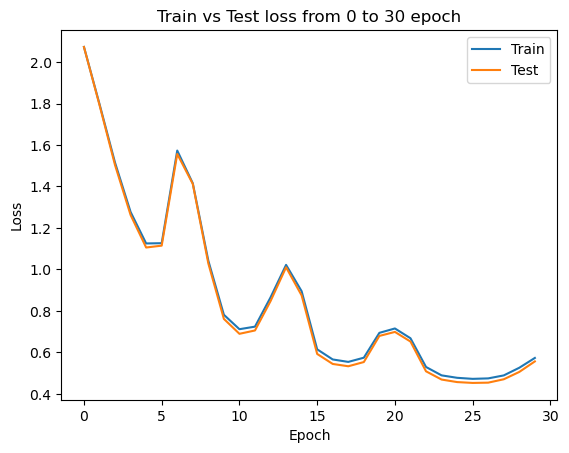

In [41]:
model.plot()

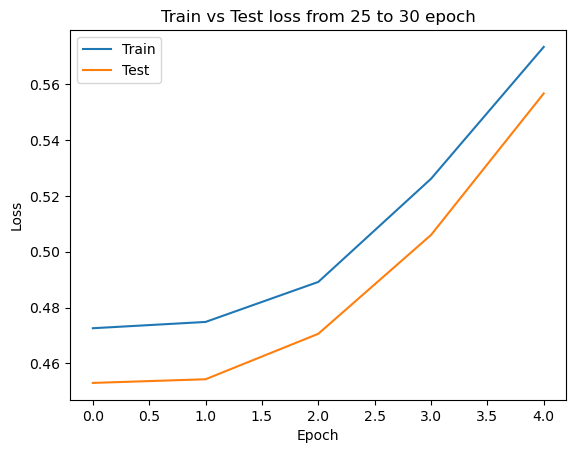

In [42]:
model.plot(from_epoch=25, to_epoch=30)